In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline
#%matplotlib widget

In [2]:
import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt
from methods import *
from plotting_functions import *

In [3]:
def jacobian(tuplerise_inputs=True, tuplerise_outputs=True, **kwargs):
    """
    Effort to vectorise, through tuplisation, the jacobian
    
    !UNUSED!
    """
    # tuplerise outer dim of input and outer
    kwargs["inputs"] = tuple([inp for inp in kwargs["inputs"]]) if tuplerise_inputs else kwargs["inputs"]
    kwargs["func"] = lambda inp: tuple([out for out in kwargs["func"](inp)]) if tuplerise_outputs else kwargs["func"]
    return torch.autograd.functional.jacobian(**kwargs)

In [4]:
class GridPhases(torch.nn.Module):
    """
    torch model for learning optimal grid cell phases
    """
    def __init__(self, f=1, init_rot=0, dtype=torch.float32, **kwargs):
        super(GridPhases, self).__init__(**kwargs)
        # init static grid properties
        self.f, self.init_rot, self.dtype = f, init_rot, dtype
        rotmat_init = rotation_matrix(init_rot)
        rotmat_60 = rotation_matrix(60)
        k1 = np.array([1.0, 0.0])
        k1 = rotmat_init @ k1
        ks = np.array([np.linalg.matrix_power(rotmat_60, k) @ k1 for k in range(3)])
        ks = torch.tensor(ks, dtype=dtype)
        self.ks = ks * f * 2 * np.pi
        # init trainable phases
        inner_hexagon = Hexagon(f/np.sqrt(3),init_rot,np.zeros(2))
        phases = inner_hexagon.sample(3)
        self.phases = torch.nn.Parameter(torch.tensor(phases,dtype=dtype,requires_grad=True))
        self.relu = torch.nn.ReLU()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        
    def forward(self, r, rectify=False, unit_scale=False, cells_first=False):
        phases = self.phases
        for _ in range(r.ndim - 1):
            # expand phases to include the spatial dims given by r
            phases = phases[:,None]
        r = r[None] # empty dim for number of phases/grid cells
        activity = torch.cos((r - phases) @ self.ks.T)
        activity = torch.sum(activity, axis=-1) # sum plane waves
        activity = self.relu(activity) if rectify else activity
        if unit_scale:
            activity -= torch.amin(activity,dim=tuple(range(1,activity.ndim)),keepdims=True)
            activity /= torch.amax(activity,dim=tuple(range(1,activity.ndim)),keepdims=True)
        return activity if cells_first else torch.permute(activity, tuple(list(range(1,len(activity.shape))) + [0]))
    
    def jacobian(self, r):
        phases = self.phases
        for _ in range(r.ndim - 1):
            # expand phases to include the spatial dims given by r
            phases = phases[:,None]
        J_tmp = -torch.sin((r - phases) @ self.ks.T)
        Jx = torch.sum(J_tmp * self.ks[:,0],axis=-1)
        Jy = torch.sum(J_tmp * self.ks[:,1],axis=-1)
        Jx = torch.transpose(Jx,0,-1)
        Jy = torch.transpose(Jy,0,-1)
        J = torch.stack([Jx,Jy],axis=-1)
        return J
            
    def the_jacobian(self, J, sqrt=True):
        """
        Parameters:
            J (f1, f2, ..., fn, ncells, 2)
        """
        det = torch.linalg.det(torch.transpose(J, -2, -1) @ J)
        return torch.sqrt(det) if sqrt else det
    
    def jacobian_det(self, r):
        """    
        UNUSED
        
        the torch jacobian is a bit nasty. It doesn't deal well with tensors for some reason..
        It instead deals with tuples of tensors. To navigate around this, we can use python
        map() to map each element of the (previously) vectorised inputs.
        
        OBS! This sux bcause it is non-differentiably (wrt. torch autograd) implemented...
        
        Parameters:
            r (nsamples, 2)
        """
        J = torch.stack(list(map(lambda r: torch.autograd.functional.jacobian(self.forward, r), r)))
        J2 = torch.transpose(J, -2, -1) @ J
        return torch.sqrt(torch.linalg.det(J2))
    
    def loss_fn(self, the_jacobian):
        return torch.var(the_jacobian,unbiased=True)
    
    def train_step(self, r):
        self.optimizer.zero_grad(set_to_none = True)
        J = self.jacobian(r)
        the_jacobian = self.the_jacobian(J)
        loss = self.loss_fn(the_jacobian)
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def train(self, r, mb_size=64, nepochs=100):
        """
        UNUSED
        """
        # INCOMPLETE
        for r_mb in range(r.shape[0] // mb_size):
            a = 2
        return None
    
    def ratemaps_from_board(self, board):
        ratemaps1d = self(board.reshape(-1,2)).detach().numpy()
        ratemaps2d = ratemaps1d.reshape(*[int(np.sqrt(ratemaps1d.shape[0]))]*2,-1)
        return ratemaps1d, ratemaps2d
    
    def imshow_ratemaps(self, board, fig=None, axs=None):
        ratemaps1d, ratemaps2d = self.ratemaps_from_board(board)
        if axs is None:
            fig,axs = plt.subplots(ncols=ratemaps2d.shape[-1])
            [axs[i].imshow(ratemaps2d[...,i]) for i in range(len(axs))]
        return fig, axs

(<Figure size 432x288 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

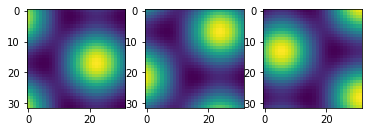

In [16]:
nx,ny = 1.2,1.2 # board size
res = 32

# initialize board
xx, yy = np.meshgrid(
    np.linspace(-nx/2, nx/2, res),
    np.linspace(-ny/2, ny/2, res),
)
board = np.stack([xx, yy], axis=-1)
board = torch.tensor(board,dtype=torch.float32)
# Init model
model = GridPhases()
# show cells
model.imshow_ratemaps(board)

100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1036.87it/s]


(<Figure size 432x288 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

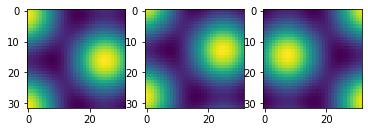

In [23]:
# Train model
loss_history = []
phases_history = [model.phases.clone().detach().numpy()]
for epoch in tqdm.trange(1000):
    loss = model.train_step(board.reshape(-1,2))
    loss_history.append(loss)
    phases_history.append(model.phases.clone().detach().numpy())
model.imshow_ratemaps(board)

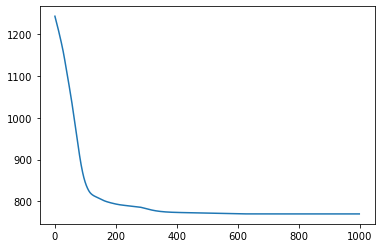

In [18]:
plt.plot(loss_history)

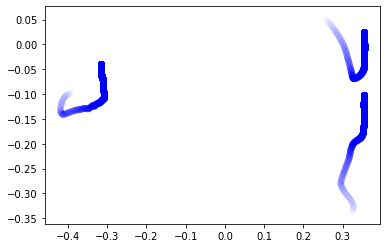

In [19]:
N = len(phases_history)
[plt.scatter(*phases_history[i].T, c='blue', alpha=i/N) for i in range(N)];

In [20]:
phases_history[-1]

array([[ 0.35558784,  0.02550625],
       [ 0.35462734, -0.10107475],
       [-0.3151679 , -0.04017518]], dtype=float32)

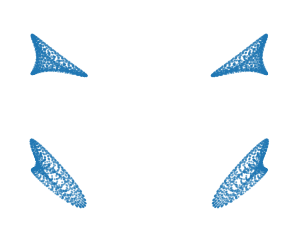

In [21]:
scatter3d(model.forward(board.reshape(-1,2)).detach().numpy(),ncols=2, nrows=2,azim_elev_title=False);

In [14]:
from ripser import ripser
from persim import plot_diagrams

NameError: name 'ratemaps' is not defined

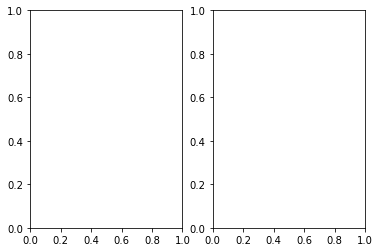

In [15]:
fig,axs = plt.subplots(ncols=2)
#dgms = ripser(g,maxdim=2,n_perm=150)['dgms']
dgms = ripser(ratemaps.reshape(ratemaps.shape[0],-1).T,maxdim=2,n_perm=150)['dgms']
plot_diagrams(dgms, show=False, ax=axs[0])
axs[1].hist(dgms[1][:,1] - dgms[1][:,0])